Run on NERSC

In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [39]:
rlimits = {}
rlimits['g'] = 1, 8, 20, 200
rlimits['r'] = 1, 7, 20, 200
rlimits['z'] = 1, 7, 20, 200

field = 'south'
output_name = 'decals_ngc'

ls_mag_bins = [10.5, 11.75, 13.0, 14.25, 15.5]
ls_mag_bright = 6.5

poly_all = []

--------------------------------------------------------------------------------------
south decals_ngc g-band
        5          4         3         2
-0.077 x - 0.2577 x + 1.984 x - 2.181 x - 3.396 x - 2.231


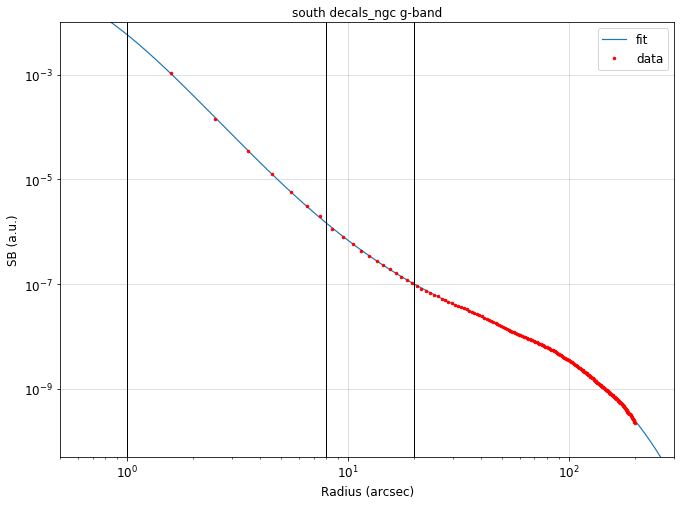

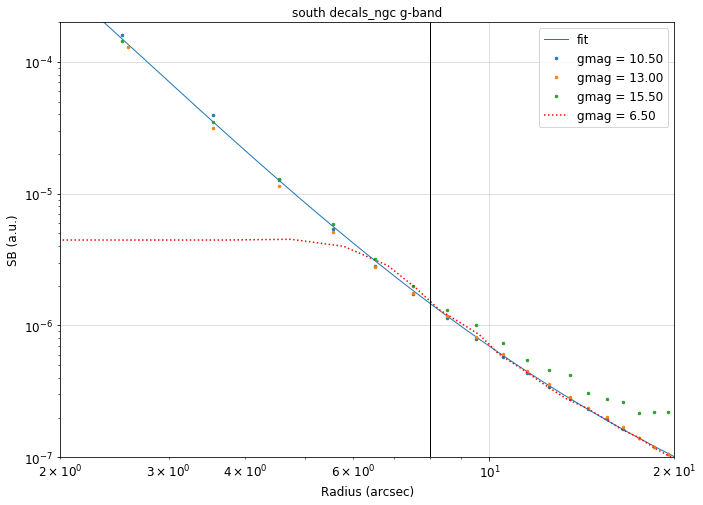

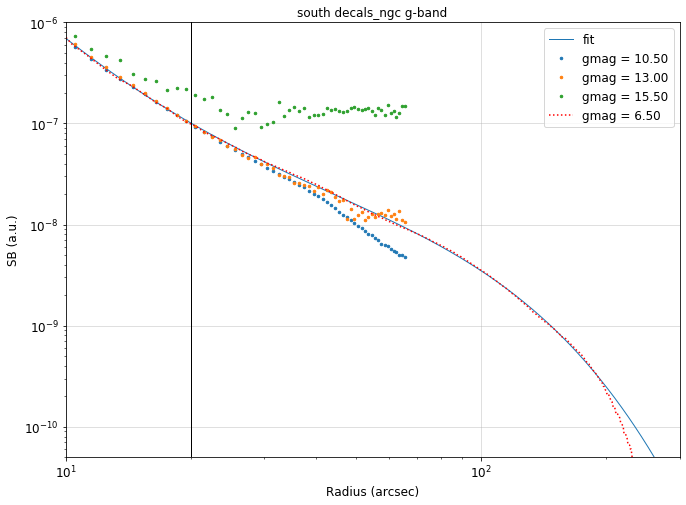

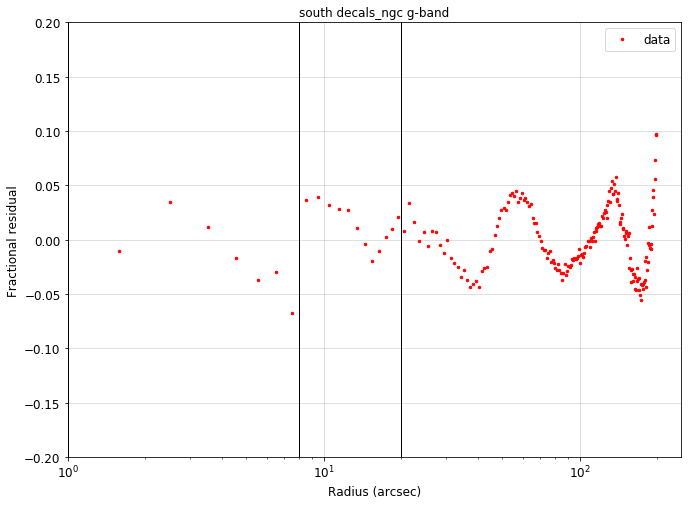

--------------------------------------------------------------------------------------
south decals_ngc r-band
         5         4          3         2
-0.1829 x + 0.394 x + 0.6065 x - 1.176 x - 3.478 x - 2.332


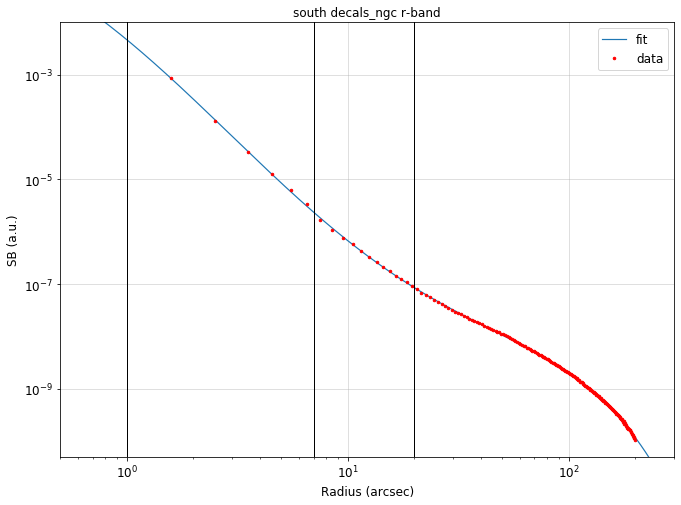

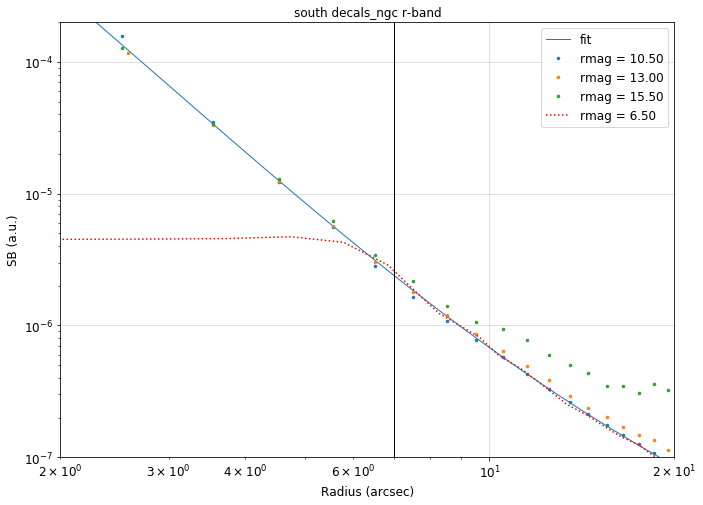

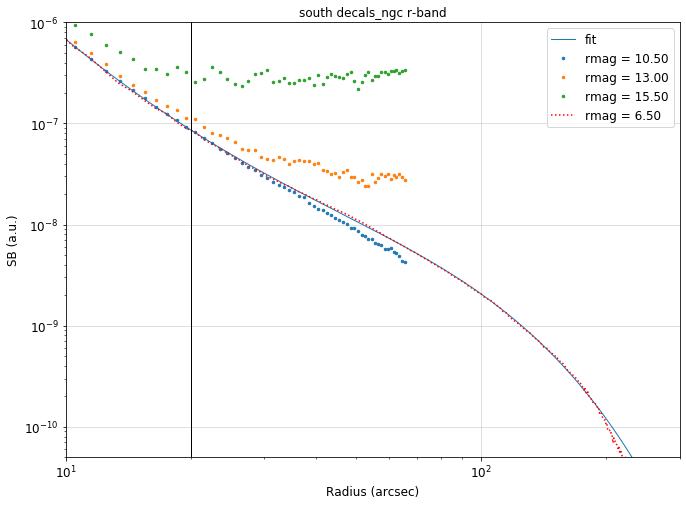

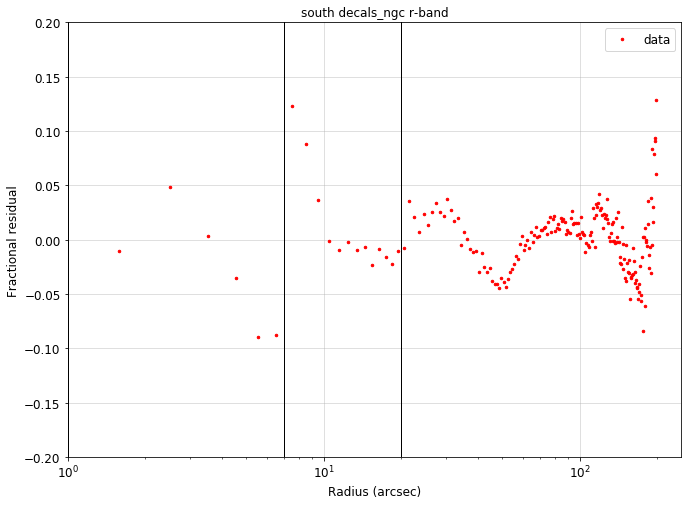

--------------------------------------------------------------------------------------
south decals_ngc z-band
        5         4         3         2
0.3298 x - 2.062 x + 4.241 x - 2.969 x - 3.015 x - 2.337


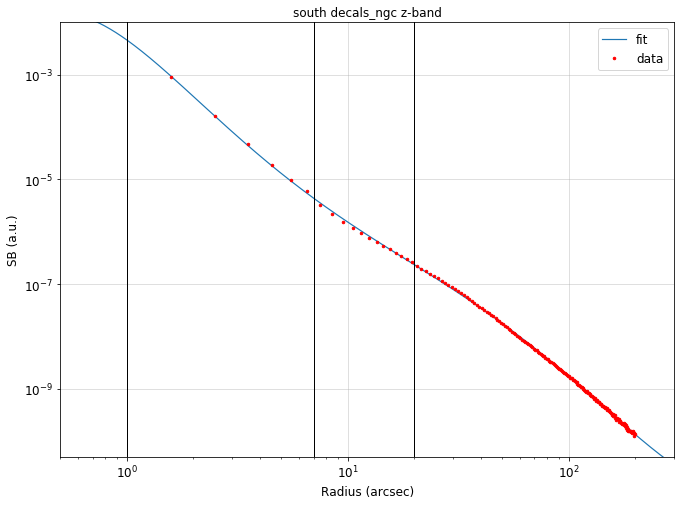

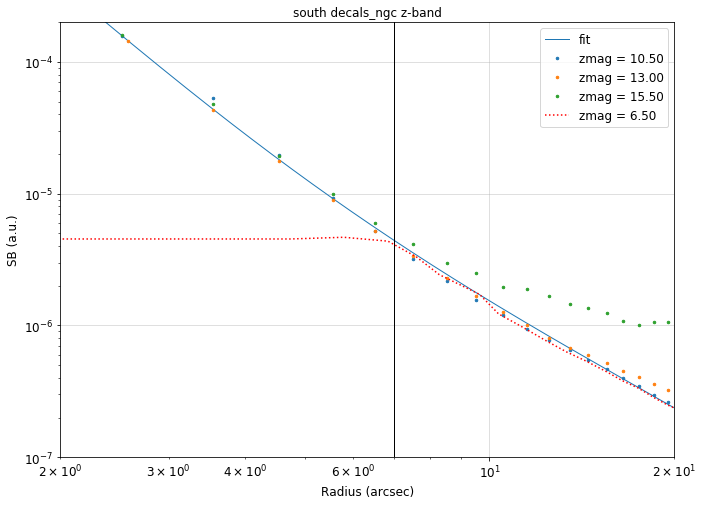

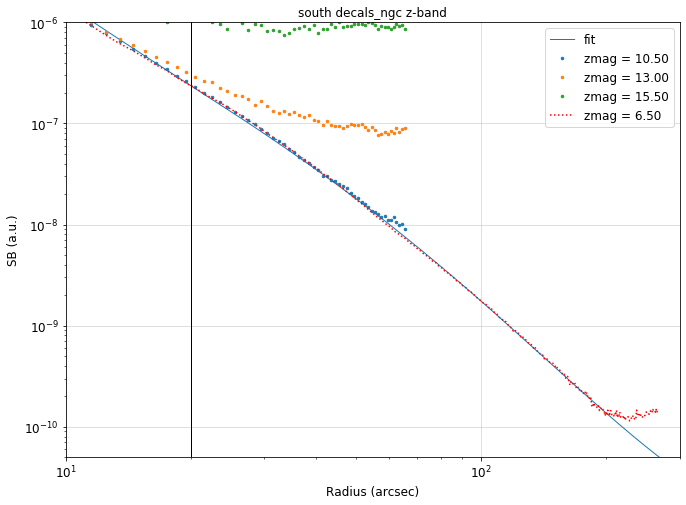

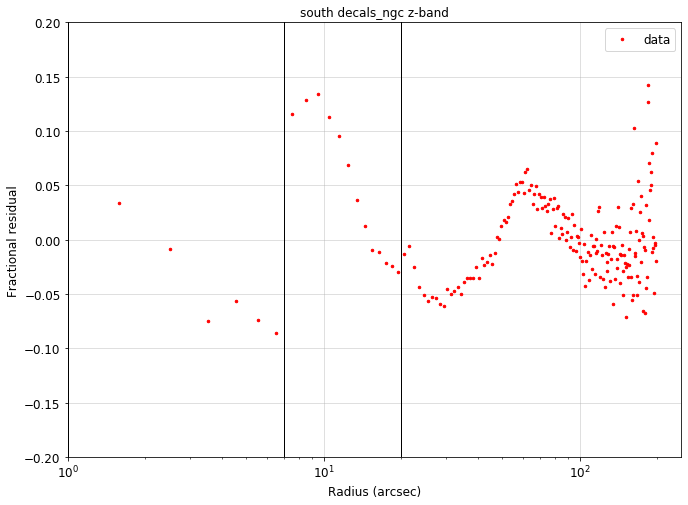

In [40]:
for band in ['g', 'r', 'z']:
    
    print('--------------------------------------------------------------------------------------')
    print('{} {} {}-band'.format(field, output_name, band))
    
    if (field=='north') and ((band=='g') or (band=='r')):
        pixscale_native = 0.454
    else:
        pixscale_native = 0.262
    # pixscale = 0.262 # pixscale for cutout queries

    r1, r2, r3, rmax = rlimits[band]

    ##############################################################################

    profile = Table.read('../data/average_profiles_{}_{}_{}.txt'.format(field, output_name, band), format='ascii.commented_header')
    indiv = Table.read('../data/individual_profiles_{}_{}_{}.fits'.format(field, output_name, band))

    profile_bright = Table.read('../data/average_profiles_{}_{}_{}-bright.txt'.format(field, output_name, band), format='ascii.commented_header')
    indiv_bright = Table.read('../data/individual_profiles_{}_{}_{}-bright.fits'.format(field, output_name, band))

    # stitch together the profiles of two magnitude bins
    index = -1
    # normalize to the flux of a 22.5 mag star per pixel
    norm = 10**((ls_mag_bins[index]-22.5)/2.5) * pixscale_native**2
    x = profile['radius_{}_{:.2f}'.format(band, ls_mag_bins[index])]
    y = norm * profile['flux_{}_{:.2f}'.format(band, ls_mag_bins[index])]
    mask = (x>r1) & (x<r2)
    xdata = x[mask]
    ydata = y[mask]

    index = 0
    # normalize to the flux of a 22.5 mag star per pixel
    norm = 10**((ls_mag_bins[index]-22.5)/2.5) * pixscale_native**2
    x = profile['radius_{}_{:.2f}'.format(band, ls_mag_bins[index])]
    y = norm * profile['flux_{}_{:.2f}'.format(band, ls_mag_bins[index])]
    mask = (x>=r2) & (x<r3)
    xdata = np.concatenate((xdata, x[mask]))
    ydata = np.concatenate((ydata, y[mask]))

    # normalize to the flux of a 22.5 mag star per pixel
    norm = 10**((ls_mag_bright-22.5)/2.5) * pixscale_native**2
    x = profile_bright['radius_{}_{:.2f}'.format(band, ls_mag_bright)]
    y = norm * profile_bright['flux_{}_{:.2f}'.format(band, ls_mag_bright)]
    mask = (x>=r3) & (x<rmax)
    xdata = np.concatenate((xdata, x[mask]))
    ydata = np.concatenate((ydata, y[mask]))

    ##############################################################################
    # 5th-order polynomial

    xlog, ylog = np.log10(xdata), np.log10(ydata)
    poly = np.polyfit(xlog, ylog, deg=5)
    poly_all.append(poly)
    profile_fit = np.poly1d(poly)
    print(profile_fit)

    # xfit = np.linspace(0.1, 300, 2000)
    xfit = np.logspace(-1, 3, 2000)
    yfit = 10**(profile_fit(np.log10(xfit)))

    plt.figure(figsize=(11, 8))
    plt.loglog(xfit, yfit, '-', lw=1.2, alpha=1., 
               label='fit', c='C0')
    plt.loglog(xdata, ydata, '.', lw=1.2, alpha=1., ms=5.,
               label='data', c='r')
    plt.title('{} {} {}-band'.format(field, output_name, band))
    plt.axis([0.5, 300, 5e-11, 1e-2])
    plt.grid(alpha=0.5)
    plt.xlabel('Radius (arcsec)')
    plt.ylabel('SB (a.u.)')
    plt.axvline(r1, lw=1, color='k')
    plt.axvline(r2, lw=1, color='k')
    plt.axvline(r3, lw=1, color='k')
    plt.legend()
    plt.show()

    plt.figure(figsize=(11, 8))
    plt.loglog(xfit, yfit, '-', lw=1., alpha=1., 
               label='fit', c='C0')
    # for index in range(len(ls_mag_bins)):
    for index in [0, 2, 4]:
        # normalize the flux to 22.5 magnitude stars
        norm = 10**((ls_mag_bins[index]-22.5)/2.5) * pixscale_native**2
        x = profile['radius_{}_{:.2f}'.format(band, ls_mag_bins[index])]
        y = norm * profile['flux_{}_{:.2f}'.format(band, ls_mag_bins[index])]
        plt.loglog(x, y, '.', lw=1.2, alpha=1., ms=5.,
                   label='{}mag = {:.2f}'.format(band, ls_mag_bins[index]))
    norm = 10**((ls_mag_bright-22.5)/2.5) * pixscale_native**2
    x = profile_bright['radius_{}_{:.2f}'.format(band, ls_mag_bright)]
    y = norm * profile_bright['flux_{}_{:.2f}'.format(band, ls_mag_bright)]
    plt.loglog(x, y, lw=1.5, alpha=1., ls=':',
               label='{}mag = {:.2f}'.format(band, ls_mag_bright), c='r')
    plt.title('{} {} {}-band'.format(field, output_name, band))
    plt.axis([2, 20, 1e-7, 2e-4])
    plt.axvline(r1, lw=1, color='k')
    plt.axvline(r2, lw=1, color='k')
    plt.axvline(r3, lw=1, color='k')
    plt.grid(alpha=0.5)
    plt.xlabel('Radius (arcsec)')
    plt.ylabel('SB (a.u.)')
    plt.legend()
    plt.show()

    plt.figure(figsize=(11, 8))
    plt.loglog(xfit, yfit, '-', lw=1., alpha=1., 
               label='fit', c='C0')
    # for index in range(len(ls_mag_bins)):
    for index in [0, 2, 4]:
        # normalize the flux to 22.5 magnitude stars
        norm = 10**((ls_mag_bins[index]-22.5)/2.5) * pixscale_native**2
        x = profile['radius_{}_{:.2f}'.format(band, ls_mag_bins[index])]
        y = norm * profile['flux_{}_{:.2f}'.format(band, ls_mag_bins[index])]
        plt.loglog(x, y, '.', lw=1.2, alpha=1., ms=5.,
                   label='{}mag = {:.2f}'.format(band, ls_mag_bins[index]))
    norm = 10**((ls_mag_bright-22.5)/2.5) * pixscale_native**2
    x = profile_bright['radius_{}_{:.2f}'.format(band, ls_mag_bright)]
    y = norm * profile_bright['flux_{}_{:.2f}'.format(band, ls_mag_bright)]
    plt.loglog(x, y, lw=1.5, alpha=1., ls=':',
               label='{}mag = {:.2f}'.format(band, ls_mag_bright), c='r')
    plt.title('{} {} {}-band'.format(field, output_name, band))
    plt.axis([10, 300, 5e-11, 1e-6])
    plt.axvline(r1, lw=1, color='k')
    plt.axvline(r2, lw=1, color='k')
    plt.axvline(r3, lw=1, color='k')
    plt.grid(alpha=0.5)
    plt.xlabel('Radius (arcsec)')
    plt.ylabel('SB (a.u.)')
    plt.legend()
    plt.show()

    ydata_fit = 10**(profile_fit(np.log10(xdata)))
    plt.figure(figsize=(11, 8))
    plt.semilogx(xdata, (ydata_fit-ydata)/ydata, '.', lw=1.2, alpha=1., ms=5.,
               label='data', c='r')
    plt.title('{} {} {}-band'.format(field, output_name, band))
    plt.axis([1, 250, -0.2, 0.2])
    plt.grid(alpha=0.5)
    plt.xlabel('Radius (arcsec)')
    plt.ylabel('Fractional residual')
    plt.axvline(r1, lw=1, color='k')
    plt.axvline(r2, lw=1, color='k')
    plt.axvline(r3, lw=1, color='k')
    plt.legend()
    plt.show()

In [41]:
for index, band in enumerate(['g', 'r', 'z']):
    print(band, poly_all[index])

g [-0.07700327 -0.25765476  1.98431054 -2.18092478 -3.39578002 -2.23083011]
r [-0.18288912  0.39400814  0.60645618 -1.17564465 -3.47811118 -2.33184959]
z [ 0.32980342 -2.06219332  4.24074568 -2.96914008 -3.01504171 -2.33686997]


In [42]:
np.savetxt('../data/{}_poly_fit.txt'.format(output_name), poly_all)